In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt


Load and prepare the dataset

In [2]:
# Load your data
df = pd.read_csv("../data/BrentOilPrices.csv")

# Convert date column
df['Date'] = pd.to_datetime(df['Date'])

# Sort and set index
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Use monthly average to smooth noise
monthly_df = df.resample('M').mean()


C:\Users\mijuu\AppData\Local\Temp\ipykernel_5280\1274583464.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\mijuu\AppData\Local\Temp\ipykernel_5280\1274583464.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M').mean()


Apply Change Point Detection

In [9]:
# Extract the price series
signal = monthly_df['Price'].values

# Define model and fit
model = rpt.Pelt(model="rbf").fit(signal)

# Choose a penalty value (tune this to detect more or fewer changes)
penalty = 10
change_points = model.predict(pen=penalty)

# Print the change points (these are index positions in the monthly_df)
print("Detected change points:", change_points)


Detected change points: [205, 285, 330, 410, 427]


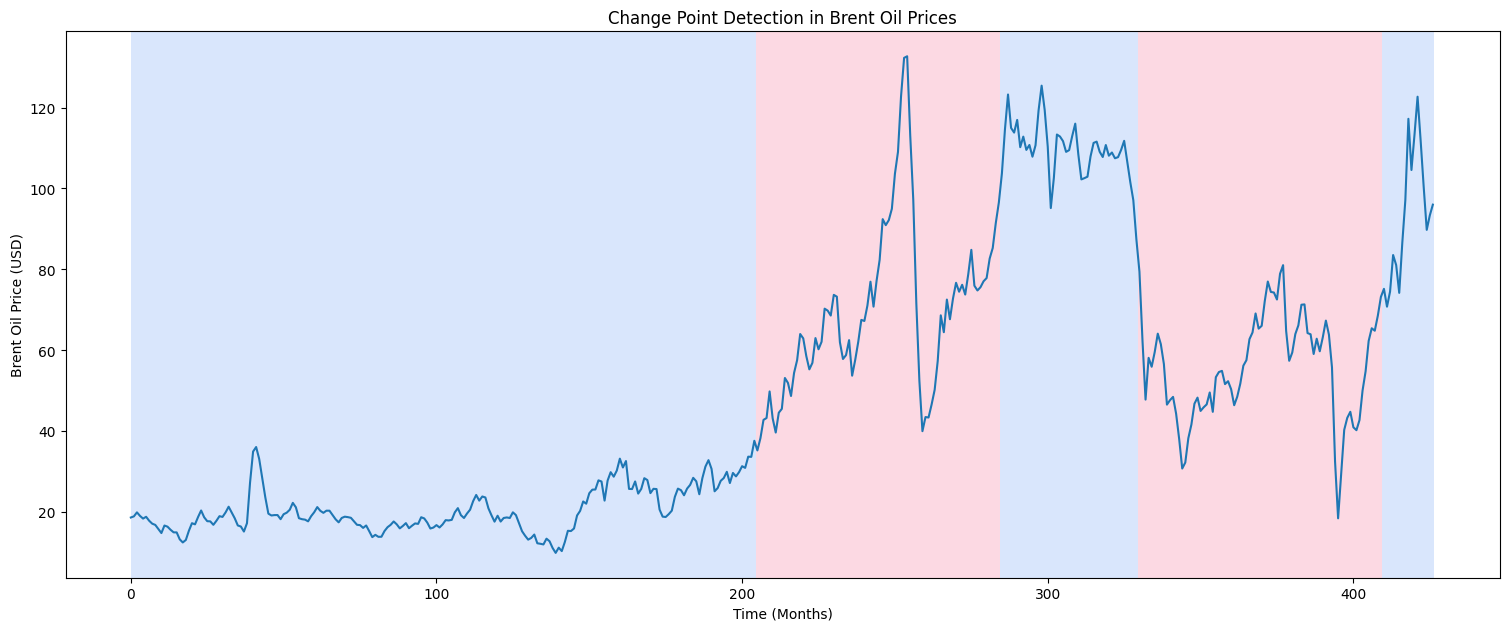

In [4]:
# Plot
rpt.display(signal, change_points, figsize=(15, 6))
plt.title("Change Point Detection in Brent Oil Prices")
plt.xlabel("Time (Months)")
plt.ylabel("Brent Oil Price (USD)")
plt.show()


In [10]:
for cp in change_points:
    if cp < len(monthly_df):
        print(f"Change point at: {monthly_df.index[cp]} - Price: {signal[cp]}")


Change point at: 2004-06-30 00:00:00 - Price: 35.18363636363636
Change point at: 2011-02-28 00:00:00 - Price: 103.71631578947368
Change point at: 2014-11-30 00:00:00 - Price: 79.4378947368421
Change point at: 2021-07-31 00:00:00 - Price: 75.1659090909091


In [13]:
# Load your event dataset (update path if needed)
events_df = pd.read_csv("../data/oil_price_events.csv")
events_df["Date"] = pd.to_datetime(events_df["Date"])  

comparison window

In [17]:
from datetime import timedelta

tolerance = timedelta(days=15)

for cp in change_points:
    if cp >= len(monthly_df):
        print(f"⚠️ Skipped invalid change point index: {cp}")
        continue

    cp_date = monthly_df.index[cp]
    matched = False
    for _, row in events_df.iterrows():
        if abs(cp_date - row["Date"]) <= tolerance:
            print(f"""
📌 Change Point: {cp_date.date()}
Matched Event: {row['Event']} on {row['Date'].date()}
Description: {row['Description']}
""")
            matched = True
            break
    if not matched:
        print(f"❌ Change Point at {cp_date.date()} — No matching event found within ±15 days.\n")


❌ Change Point at 2004-06-30 — No matching event found within ±15 days.

❌ Change Point at 2011-02-28 — No matching event found within ±15 days.

❌ Change Point at 2014-11-30 — No matching event found within ±15 days.


📌 Change Point: 2021-07-31
Matched Event: OPEC+ dispute over production quotas on 2021-07-18
Description: Temporary price volatility amid output uncertainty.

⚠️ Skipped invalid change point index: 427


In [22]:
from datetime import timedelta
import json

window = 3  # number of months before and after for average price comparison
cp_dates = []  # we'll populate this

for cp in change_points:
    if cp >= len(monthly_df):
        continue

    cp_date = monthly_df.index[cp]
    cp_dates.append(cp_date)  # add this date to the list

    # Try to match with an event
    matched_event = None
    for _, row in events_df.iterrows():
        if abs(cp_date - row["Date"]) <= timedelta(days=15):
            matched_event = row
            break

    # Calculate mean price before and after
    start_before = max(cp - window, 0)
    end_before = cp
    start_after = cp + 1
    end_after = min(cp + window + 1, len(monthly_df))

    mean_before = monthly_df["Price"].iloc[start_before:end_before].mean()
    mean_after = monthly_df["Price"].iloc[start_after:end_after].mean()
    pct_change = ((mean_after - mean_before) / mean_before) * 100

    if matched_event is not None:
        print(f"""
📈 Change Detected at: {cp_date.date()}
Event: {matched_event['Event']} on {matched_event['Date'].date()}
Description: {matched_event['Description']}
Price before: ${mean_before:.2f}
Price after:  ${mean_after:.2f}
Change: {mean_after - mean_before:.2f} USD ({pct_change:.2f}%)
""")

# ✅ Now export the dates
cp_dates_str = [d.strftime('%Y-%m-%d') for d in cp_dates]
with open("../brent-dashboard/backend/data/change_points.json", "w") as f:
    json.dump(cp_dates_str, f)



📈 Change Detected at: 2021-07-31
Event: OPEC+ dispute over production quotas on 2021-07-18
Description: Temporary price volatility amid output uncertainty.
Price before: $68.83
Price after:  $76.26
Change: 7.42 USD (10.78%)



In [19]:
monthly_df.to_csv("../brent-dashboard/backend/data/oil_prices.csv")

In [25]:
# Ensure the Date column is in datetime format
events_df["Date"] = pd.to_datetime(events_df["Date"])

# Now convert to string format (YYYY-MM-DD)
events_df["Date"] = events_df["Date"].dt.strftime('%Y-%m-%d')

# Save to JSON
events_df.to_json("../brent-dashboard/backend/data/events.json", orient="records")

